In [1]:
from models.det_allhist_glm import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub9_C_syn_e.npy"
C_syn_i_file = "handsub9_C_syn_i.npy"
C_den_file = "handsub9_C_den_flat.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [3]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 2500
epoch_no = 50
layer_no = 3

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

236


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_Z_pred).item(),
             model.W_out.item(),
             model.Tau_out.item())


<ipython-input-6-9abb0e8d5fb6>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -143.965347 4.023395 6290.0 0.7003732323646545 -1.413249135017395
199 -30.293633 0.779888 2914.0 0.6505157351493835 -1.374524712562561
299 -14.958936 0.363641 1808.0 0.6350160837173462 -1.3637908697128296
399 -4.985215 0.130477 1137.0 0.6250818371772766 -1.3572310209274292
499 -2.786831 0.081641 954.0 0.6198945641517639 -1.3538421392440796
599 -2.706658 0.079883 935.0 0.6176254153251648 -1.35245680809021
699 -2.222148 0.069212 872.0 0.6144225001335144 -1.350516438484192
799 -1.648919 0.056747 809.0 0.6107114553451538 -1.3483390808105469
899 -1.434431 0.052133 789.0 0.6080528497695923 -1.346786618232727
999 -1.386359 0.051074 761.0 0.6050357222557068 -1.3449724912643433
1099 -1.179248 0.046621 719.0 0.6021528244018555 -1.3432461023330688
1199 -0.930722 0.041297 676.0 0.5988481640815735 -1.3414305448532104
1299 -0.710154 0.036601 628.0 0.5963770151138306 -1.3400286436080933
1399 -0.49914 0.03212 589.0 0.5927345752716064 -1.3379459381103516
1499 -0.508461 0.03231 590.0 0.59122425317764

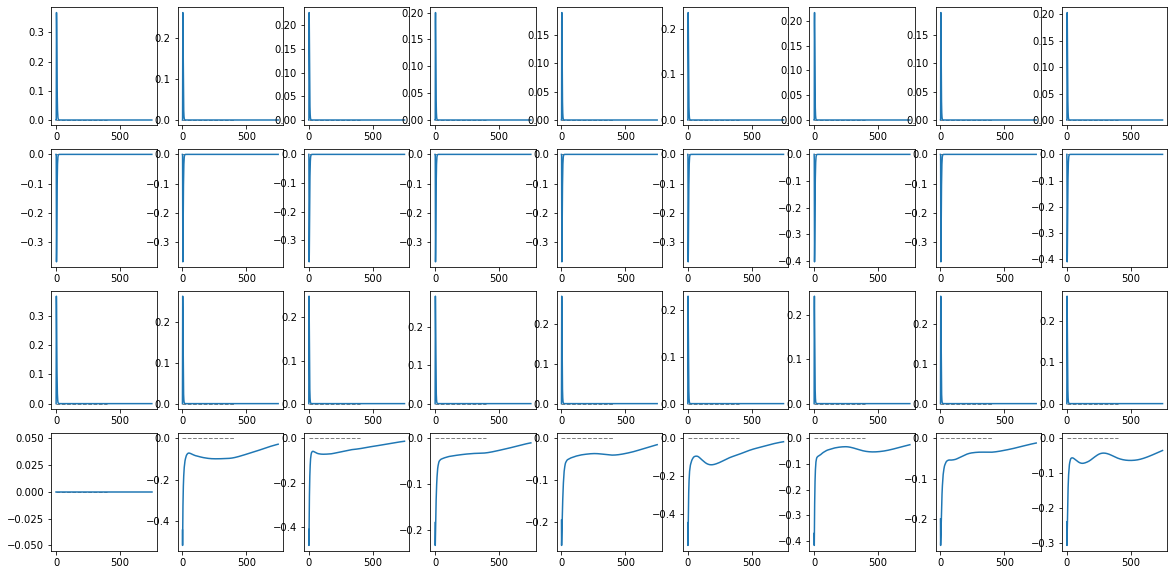

In [7]:
sub_no = 9
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(20,10))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

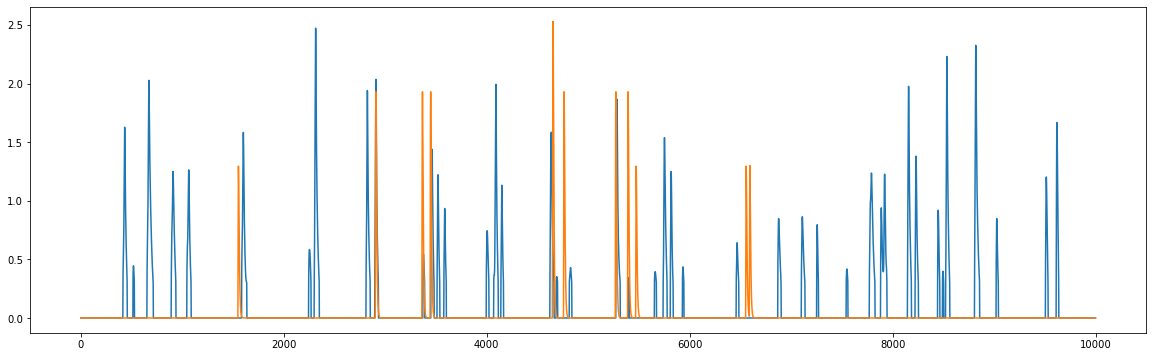

In [8]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


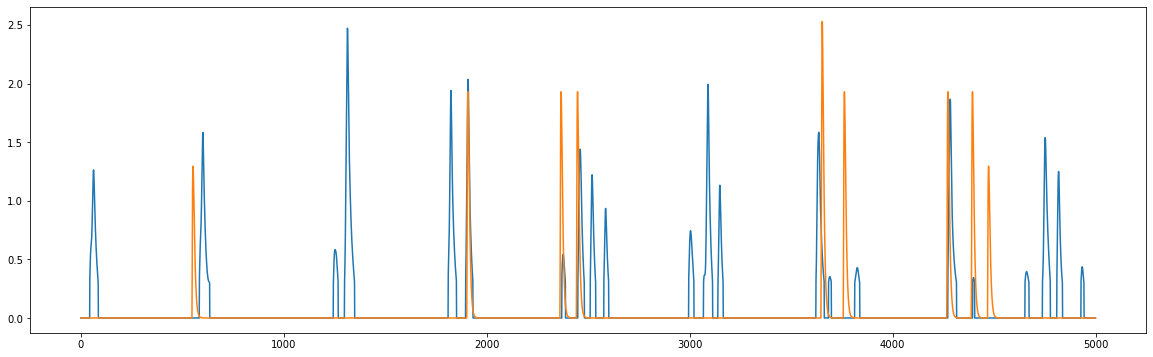

In [9]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][1000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][1000:6000])


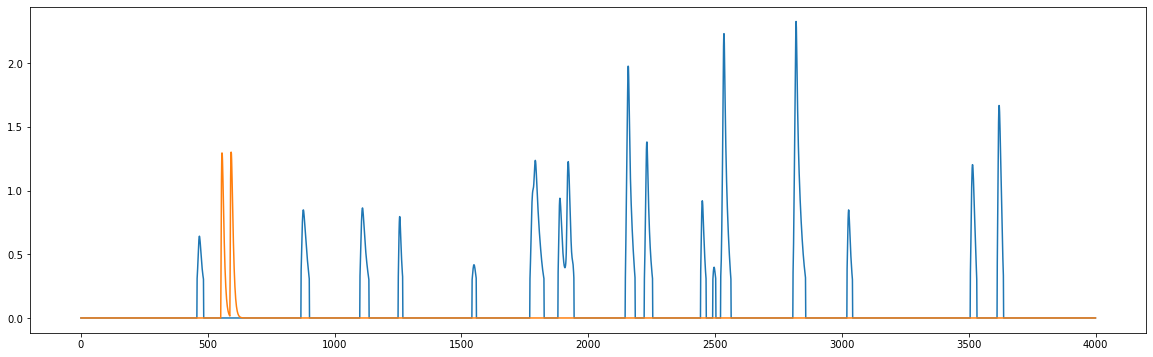

In [10]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][6000:10000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][6000:10000])


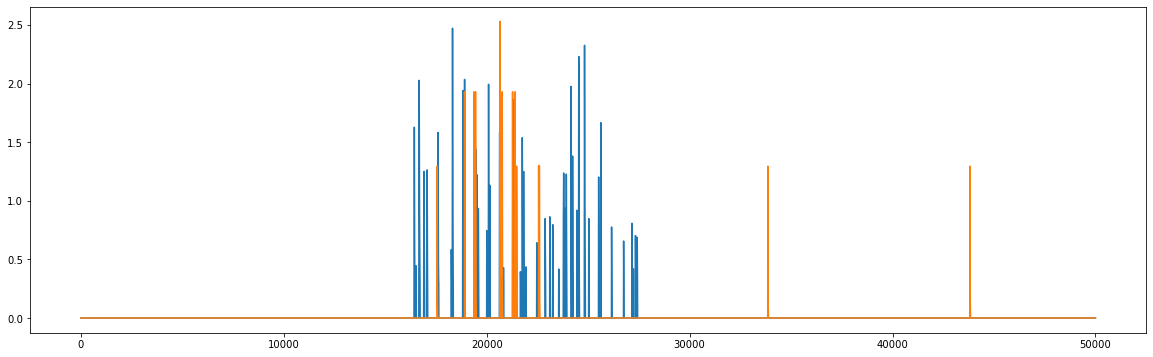

In [11]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy()[:])
